In [1]:
# Imports and Device Setup

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import os

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

Using device: cpu


# Data Transforms (VGG19 requires 224×224 + ImageNet normalization)

In [4]:
data_path = Path("fooddata/")
train_dir = data_path / "train"
test_dir = data_path / "test"

In [5]:
train_dir

WindowsPath('fooddata/train')

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Dataset Directly

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                   transform=manual_transforms)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=manual_transforms)

class_names = train_data.classes

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)

print("Classes:", class_names)

Classes: ['pizza', 'steak', 'sushi']


In [8]:
len(train_data)

225

In [9]:
print("Number of classes:", len(class_names))

Number of classes: 3


In [10]:
print(train_data.classes)
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [11]:
for i in range(5):
    img, label = train_data[i]
    print(f"Label index: {label} | Class name: {train_data.classes[label]}")

Label index: 0 | Class name: pizza
Label index: 0 | Class name: pizza
Label index: 0 | Class name: pizza
Label index: 0 | Class name: pizza
Label index: 0 | Class name: pizza


In [12]:
# Get class index mapping
from collections import Counter
print(train_data.class_to_idx)
# Count targets
train_targets = train_data.targets
class_counts = Counter(train_targets)
for class_idx, count in class_counts.items():
    print(f"{class_names[class_idx]}: {count}")

{'pizza': 0, 'steak': 1, 'sushi': 2}
pizza: 78
steak: 75
sushi: 72


In [ ]:
plt.figure(figsize=(12,8))

for i in range(9):
    random_idx = random.randint(0, len(train_data)-1)
    img, label = train_data[random_idx]

    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))  # convert CHW → HWC
    plt.title(class_names[label])
    plt.axis(False)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


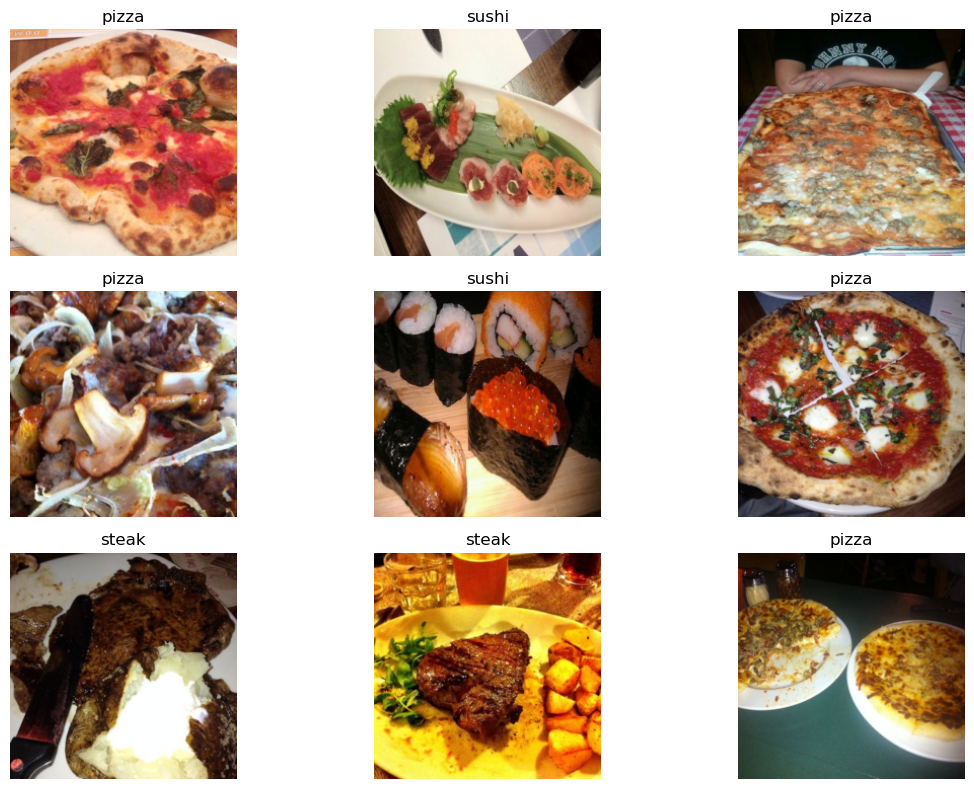

In [13]:
def unnormalize(img):
    img = img.permute(1,2,0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    return img
plt.figure(figsize=(12,8))
for i in range(9):
    random_idx = random.randint(0, len(train_data)-1)
    img, label = train_data[random_idx]
    plt.subplot(3,3,i+1)
    plt.imshow(unnormalize(img))
    plt.title(class_names[label])
    plt.axis(False)
plt.tight_layout()
plt.show()

In [13]:
print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))

Training samples: 225
Testing samples: 75


# Loading Pretrained VGG16

In [14]:
weights = torchvision.models.VGG16_Weights.DEFAULT
model = torchvision.models.vgg16(weights=weights)
model = model.to(device)

#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
#model = torchvision.models.efficientnet_b0(weights=weights)
#model = model.to(device)

In [15]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freeze Feature Extractor

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

# Replace Classifier Layer

In [18]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [19]:

#vgg16
output_shape = len(class_names)

model.classifier[6] = nn.Linear(in_features=4096,
                                out_features=output_shape)

model = model.to(device)
'''
output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280,
              out_features=output_shape)
)

model = model.to(device)
'''

'\noutput_shape = len(class_names)\n\nmodel.classifier = nn.Sequential(\n    nn.Dropout(p=0.2),\n    nn.Linear(in_features=1280,\n              out_features=output_shape)\n)\n\nmodel = model.to(device)\n'

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (1,792)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (36,928)
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       (73,856)
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       (147,584)
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      (295,168)
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      (590,080)
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      (590,080)
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      (1,180,160)
│    └─ReLU: 2-19

# Loss & Optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [23]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y)

    return train_loss/len(dataloader), train_acc/len(dataloader)

In [24]:
def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y)

    return test_loss/len(dataloader), test_acc/len(dataloader)

In [25]:
epochs = 5

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

start_time = timer()

for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

    print(f"Epoch: {epoch+1}")
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    print("-"*30)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1
Train loss: 1.3004 | Train acc: 0.6523
Test loss: 2.7246 | Test acc: 0.4271
------------------------------
Epoch: 2
Train loss: 0.3942 | Train acc: 0.8984
Test loss: 0.4773 | Test acc: 0.8447
------------------------------
Epoch: 3
Train loss: 0.0990 | Train acc: 0.9609
Test loss: 0.8755 | Test acc: 0.8958
------------------------------
Epoch: 4
Train loss: 0.1247 | Train acc: 0.9766
Test loss: 2.9343 | Test acc: 0.7945
------------------------------
Epoch: 5
Train loss: 0.3656 | Train acc: 0.9727
Test loss: 1.5706 | Test acc: 0.8665
------------------------------
Total training time: 525.262 seconds


In [29]:
from sklearn.metrics import classification_report
model.eval()

all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        y_logits = model(X)
        y_pred = torch.argmax(y_logits, dim=1)

        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
print(classification_report(all_labels, 
                            all_preds, 
                            target_names=class_names))

              precision    recall  f1-score   support

       pizza       1.00      0.84      0.91        25
       steak       0.76      1.00      0.86        19
       sushi       0.90      0.84      0.87        31

    accuracy                           0.88        75
   macro avg       0.89      0.89      0.88        75
weighted avg       0.90      0.88      0.88        75



In [26]:
torch.save(model.state_dict(), "final_model.pth")

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(results["train_loss"], label="Train Loss")
plt.plot(results["test_loss"], label="Test Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(results["train_acc"], label="Train Acc")
plt.plot(results["test_acc"], label="Test Acc")
plt.legend()
plt.title("Accuracy")

plt.show()

In [42]:
def pred_and_plot_image(model,
                        image_path,
                        class_names,
                        transform,
                        device=device,
                        top_k=3):
    
    # 1 Load image
    img = Image.open(image_path).convert("RGB")
    
    # 2 Prepare model
    model = model.to(device)
    model.eval()
    
    # 3 Transform image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # 4 Inference
    with torch.inference_mode():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
    
    # 5 Get top-k predictions
    top_probs, top_labels = torch.topk(probs, top_k)
    
    top_probs = top_probs.cpu().numpy().flatten()
    top_labels = top_labels.cpu().numpy().flatten()
    
    # 6 Plot image
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis(False)
    
    title_text = ""
    for i in range(top_k):
        class_name = class_names[top_labels[i]]
        probability = top_probs[i]
        title_text += f"{class_name}: {probability:.3f}\n"
    
    plt.title(title_text.strip())
    plt.show()
    
    # 7 Return prediction info (useful for evaluation)
    return [(class_names[top_labels[i]], float(top_probs[i])) for i in range(top_k)]

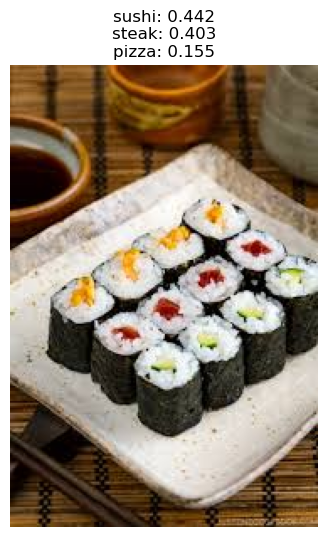

[('sushi', 0.4422415792942047),
 ('steak', 0.40285229682922363),
 ('pizza', 0.15490619838237762)]

In [47]:
pred_and_plot_image(model=model,
                    image_path="download (1).jfif",
                    class_names=class_names,
                    transform=manual_transforms,
                    device=device,
                    top_k=3)

In [33]:
for param in model.features[:21].parameters():
    param.requires_grad = False

In [34]:
print(model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [35]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True
